## Мастерская Yandex Практикума: Проект "Medical QA"
***
### Описание проекта:
Исходные данные:
[Набор пар медицинских вопросов](https://huggingface.co/datasets/medical_questions_pairs)
с метками `1` и `0` (вопросы похожи / непохожи).

Цель:
Разработать рекомендательный сервис для поиска медицинских вопросов, похожих на введенный пользователем текст.

Результаты:
* Проверили исходный датасет на отсутствие пропусков, дублирующих пар вопросов и сбалансированность меток;
* Создали корпус вопросов и добавили их id в исходный датасет;
* Применили несколько способов предобработки и векторизации текста, наибольшая точность поиска `accuracy@n` получилась у языковой модели BERT,
  предобученной на определении схожести текстов (SentenceTransformer);
* Добавили классификатор, чтобы из вопросов, ближайших к заданному по векторному расстоянию, отбирать те, для которых классификатор выдает 1. Обучение проводилось на расширенном датасете, содержащим пары вопросов в прямом и обратном порядке. Сравнили CatBoostClassifier и BERT с добавленным линейным слоем, наибольшая точность классификации на тестовой выборке получилась у BERT. В пользовательском интерфейсе добавили возможность отключения классификатора для ускорения работы;
* Создали микросервис и клиентскую часть на базе FastAPI и Streamlit соответственно.

Выполнил:
Кирилл Носов, email: ibnkir@yandex.ru, tg: [Xmg23](https://t.me/Xmg23).
***
### Ноутбук для прототипирования решения:
Содержание:

0. [Импорты библиотек и инициализация переменных](#step_0)
1. [Получение и анализ данных](#step_1)
2. [Текстовая предобработка вопросов](#step_2)
3. [Расчет точности поиска accuracy@n](#step_3)
4. [Векторизация с помощью BoW](#step_4)
5. [Векторизация с помощью TF-IDF](#step_5)
6. [Векторизация с помощью word2vec и glove](#step_6)
7. [Векторизация с помощью BERT](#step_7)
8. [Обучение классификаторов на парах вопросов](#step_8)
9. [Поиск похожих вопросов с учетом предсказаний классификатора](#step_9)

### 0. Импорты библиотек и инициализация переменных <a id="step_0"></a>

Дообучение BERT лучше проводить на GPU, для чего можно использовать, например, Google Colab.
В этом случае все файлы, включая модель, будем сохранять в `/content/sample_data`
без монтирования собственного гугл-диска. Полученные модели нужно будет потом перенести вручную в папку `/models` репозитория проекта.

In [6]:
# Проверяем, в какой среде мы сейчас работаем
from pathlib import Path
import sys

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    #google.colab.drive.mount("content/drive", force_remount=True)
    ROOT = Path("/content/sample_data/")
    sys.path.append(str(ROOT))
else:
    ROOT = Path(".")

In [3]:
#!pip install datasets # Библиотека для скачивания датасетов Hugging Face
#!pip install catboost

#!pip install fastapi
#!pip install "uvicorn[standard]"
#!pip install streamlit

In [7]:
# Импортируем необходимые библиотеки

import os

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)

from datasets import load_dataset

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, f1_score

from catboost import CatBoostClassifier, Pool

import re
from functools import lru_cache
from tqdm import tqdm
from collections import defaultdict
from multiprocessing import Pool
import random

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')

import gensim
import gensim.downloader
from gensim.models import word2vec

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_theme(style="whitegrid")

from pickle import dump

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kirill_Nosov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Инициализируем константы и генератор случайных чисел

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Кол-во случайно отбираемых вопросов для расчета точности поиска
RANDOM_CHOICE_SIZE = 100

# Кол-во ближайших векторов для расчета точности поиска
NEAREST_NUM = 5

# Сколько раз считаем точность поиска accuracy@n, чтобы найти среднее значение
ACC_CALC_NUM = 20

### 1. Получение и анализ данных <a id="step_1"></a>

Скачиваем исходный датасет с парами вопросов и проверяем его на наличие пропусков, дубликатов и сбалансированность меток.
После этого создаем корпус из всех уникальных вопросов в обеих колонках и вставляем id вопросов в исходный датасет.

In [10]:
# Скачиваем исходный датасет
if IN_COLAB and os.path.exists(f"{ROOT}/medical_questions_pairs.csv"):
    data = pd.read_csv(f"{ROOT}/medical_questions_pairs.csv")
elif not IN_COLAB and os.path.exists("../data/medical_questions_pairs.csv"):
    data = pd.read_csv("../data/medical_questions_pairs.csv")
else:
    data = load_dataset("medical_questions_pairs", split="train")
    data = pd.DataFrame(data)
    # Скачивание занимает много времени, поэтому для дальнейших экспериментов лучше сохранить датасет локально
    if IN_COLAB:
        data.to_csv(f"{ROOT}/medical_questions_pairs.csv", index=False)
    else:
        data.to_csv("../data/medical_questions_pairs.csv", index=False)

data.head()

,dr_id,question_1,question_2,label
0,1,After how many hour from drinking an antibiotic can I drink alcohol?,I have a party tonight and I took my last dose of Azithromycin this morning. Can I have a few drinks?,1
1,1,After how many hour from drinking an antibiotic can I drink alcohol?,I vomited this morning and I am not sure if it is the side effect of my antibiotic or the alcohol I took last night...,0
2,1,Am I over weight (192.9) for my age (39)?,I am a 39 y/o male currently weighing about 193 lbs. Do you think I am overweight?,1
3,1,Am I over weight (192.9) for my age (39)?,What diet is good for losing weight? Keto or vegan?,0
4,1,Aspirin allergy - is it worth getting a bracelet?,How much Aspirin can I take for my headache without causing any side effects?,0


In [11]:
# Смотрим количество строк, типы данных и наличие пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3048 entries, 0 to 3047
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   dr_id       3048 non-null   int64 
 1   question_1  3048 non-null   object
 2   question_2  3048 non-null   object
 3   label       3048 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 95.4+ KB


Пропусков нет.

Проверим датасет на наличие дубликатов. Сначала посмотрим, есть ли строки, внутри которых 1-й и 2-й вопросы полностью совпадают.
Такие строки можно сразу удалить, т.к. они не несут никакой информации и могут только ухудшить качество,
если у них по ошибке проставлена метка 0

In [120]:
cnt = (data['question_1'] == data['question_2']).sum()
print(f"Количество строк, в которых 1-й и 2-й вопросы совпадают: {cnt}")

Количество строк, в которых 1-й и 2-й вопросы совпадают: 0


Далее проверим, есть ли строки-дубликаты с одинаковыми парами вопросов (q1, q2). Внутри каждой такой группы можно будет
взять только одну строку, а в качестве метки, например, медиану по группе

In [121]:
cols_to_check = ['question_1', 'question_2']
duplicated_rows = data.duplicated(subset=cols_to_check, keep=False)
cnt = duplicated_rows.sum()
print(f"Количество строк-дубликатов с одинаковыми парами вопросов: {cnt}")

Количество строк-дубликатов с одинаковыми парами вопросов: 0


Наконец, проверим более сложный случай, когда пара (q1, q2) в одной строке совпадает с зеркальной парой (q2, q1) в другой

In [122]:
# Создаем 2 временные колонки

data['q12'] = data['question_1'] + data['question_2']
data['q21'] = data['question_2'] + data['question_1']

# Соединяем строки, в которых исходная и зеркальная пары вопросов совпадают
df_tmp = pd.merge(data, data, left_on='q12', right_on='q21')

# Выводим их количество
print(f"Количество строк-дубликатов, в которых 1-й и 2-й вопросы совпадают соответственно со 2-м и 1-м вопросами: {len(df_tmp)}")

# Удаляем временные колонки
data.drop(columns=['q12', 'q21'], inplace=True)

Количество строк-дубликатов, в которых 1-й и 2-й вопросы совпадают соответственно со 2-м и 1-м вопросами: 0


Видим, что таких дубликатов тоже нет.

Посмотрим, насколько сбалансированы метки в датасете

<Axes: xlabel='label', ylabel='count'>

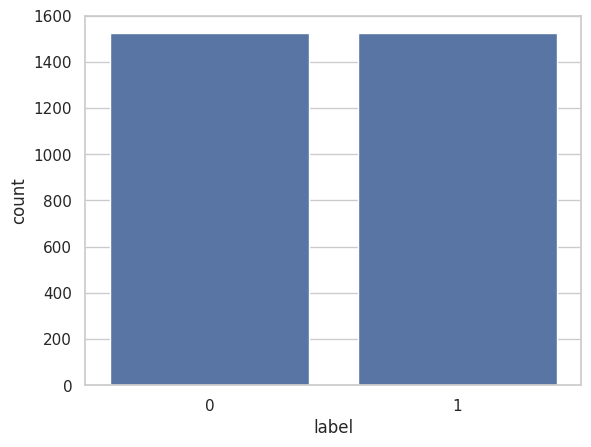

In [123]:
agg_df = pd.DataFrame(data.groupby("label").agg('count')['dr_id']).reset_index().rename(columns={'dr_id': 'count'})
sns.barplot(data=agg_df, x='label', y='count')

Видим, что все ОК, метки полностью сбалансированы (иначе пришлось бы делать, например, аугментацию данных).

Создаем корпус вопросов, который будет содержать все неповторяющиеся вопросы из обеих колонок исходного датасета

In [12]:
# Создаем корпус вопросов
questions = pd.DataFrame(pd.concat([data['question_1'], data['question_2']], axis=0).unique())
questions.reset_index(inplace=True)
questions.rename(columns={'index': 'question_id', 0: 'question'}, inplace=True)
questions.head()

,question_id,question
0,0,After how many hour from drinking an antibiotic can I drink alcohol?
1,1,Am I over weight (192.9) for my age (39)?
2,2,Aspirin allergy - is it worth getting a bracelet?
3,3,"At a doctor's visit, I hit my head against a box on the wall containing hazardous materials (used syringes, used needles...). Will I get infected?"
4,4,Been on antibiotics 4 5wks top high tooth dentist cld not get needle 2 freeze 2 extract in gum really hurt she said its the tissues hve 2 go bk? Plz


In [13]:
len(questions)

4567

Добавим к вопросам в левой и правой колонках исходного датасета их id из корпуса вопросов. 
Эти новые колонки понадобятся в функции расчета точности поиска и для обучения catboost-классификатора
на парах векторов.

In [14]:
# Добавляем id к вопросам в левой и правой колонках исходного датасета

# id вопросов из 1-й колонки
data = pd.merge(data, questions, left_on='question_1', right_on='question', how='left')
data.rename(columns={'question_id': 'question_1_id'}, inplace=True)
data.drop(columns='question', inplace=True)

# id вопросов из 2-й колонки
data = pd.merge(data, questions, left_on='question_2', right_on='question', how='left')
data.rename(columns={'question_id': 'question_2_id'}, inplace=True)
data.drop(columns='question', inplace=True)

data.head()

,dr_id,question_1,question_2,label,question_1_id,question_2_id
0,1,After how many hour from drinking an antibiotic can I drink alcohol?,I have a party tonight and I took my last dose of Azithromycin this morning. Can I have a few drinks?,1,0,1524
1,1,After how many hour from drinking an antibiotic can I drink alcohol?,I vomited this morning and I am not sure if it is the side effect of my antibiotic or the alcohol I took last night...,0,0,1525
2,1,Am I over weight (192.9) for my age (39)?,I am a 39 y/o male currently weighing about 193 lbs. Do you think I am overweight?,1,1,1526
3,1,Am I over weight (192.9) for my age (39)?,What diet is good for losing weight? Keto or vegan?,0,1,1527
4,1,Aspirin allergy - is it worth getting a bracelet?,How much Aspirin can I take for my headache without causing any side effects?,0,2,1528


В конце посмотрим на распределение длины вопросов

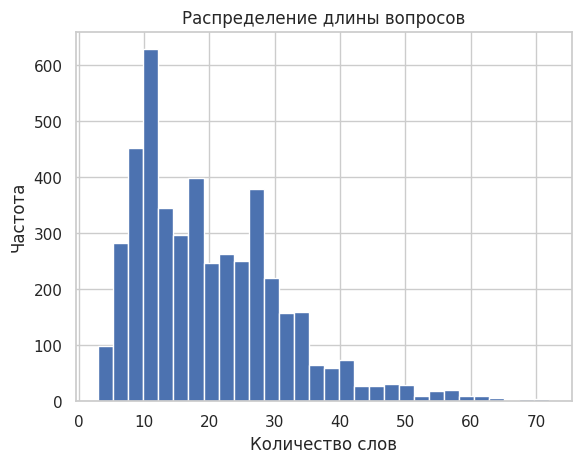

In [126]:
lens = [len(q.split()) for q in questions['question']]

plt.hist(lens, bins=30)
plt.title("Распределение длины вопросов")
plt.xlabel("Количество слов")
plt.ylabel("Частота")
plt.show()

Видим, что большинство вопросов не очень длинные. Максимальную длину учтем в параметрах BERT.
Также соответствующим образом ограничим длину текста пользователя веб-интерфейсе.

### 2. Текстовая предобработка вопросов <a id="step_2"></a>

Предобработка включает следующие шаги:
* токенизация,
* очистка полученных токенов от знаков пунктуации и числительных,
* нормализация токенов (стемматизация или лемматизация),
* удаление стоп-слов.

Попробуем 2 способа: библиотеку nltk со стемматизацией и библиотеку spacy с лемматизацией.

__Предобработка с помощью библиотеки nltk и стемматизации__

In [ ]:
# Вспомогательные функции

# Стемматизация одного слова
# (устанавливаем размер кэша примерно равным ожидаемому количеству слов во всем корпусе вопросов)
@lru_cache(maxsize=5000)
def stemmatize_word(word, stemmer=PorterStemmer()):
    return stemmer.stem(word)

# Стемматизация списка слов
def stemmatize_words(words):
    return [stemmatize_word(w) for w in words]

# Удаление стоп-слов из списка стем
mystopwords = stopwords.words('english')
def remove_stopwords(stems, stopwords=mystopwords):
    return [s for s in stems if not s in stopwords]

# Токенизация с выделением только английских слов размером от 3-х символов и выше
regex = re.compile("[a-zA-Z]{3,}")
def get_words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

# Функция для предобработки одного документа (в нашем случае - это один вопрос из корпуса вопросов)
def preproc_text(text):
    words = get_words_only(text)
    stems = stemmatize_words(words)
    return ' '.join(remove_stopwords(stems))

In [ ]:
# Запускаем обработку колонки 'question' в корпусе вопросов
with Pool(8) as p:
    stems = list(tqdm(map(preproc_text, questions['question']), total=len(questions)))

# Добавляем колонку stems
questions['stems'] = stems
questions.head()

100%|████████████████████████████████████████████████████████████████████████████| 4567/4567 [00:00<00:00, 4790.74it/s]


,question_id,question,stems
0,0,After how many hour from drinking an antibiotic can I drink alcohol?,mani hour drink antibiot drink alcohol
1,1,Am I over weight (192.9) for my age (39)?,weight age
2,2,Aspirin allergy - is it worth getting a bracelet?,aspirin allergi worth get bracelet
3,3,"At a doctor's visit, I hit my head against a box on the wall containing hazardous materials (used syringes, used needles...). Will I get infected?",doctor visit hit head box wall contain hazard materi use syring use needl get infect
4,4,Been on antibiotics 4 5wks top high tooth dentist cld not get needle 2 freeze 2 extract in gum really hurt she said its the tissues hve 2 go bk? Plz,antibiot wk top high tooth dentist cld get needl freez extract gum realli hurt said tissu hve plz


__Предобработка с помощью библиотеки spacy и лемматизации__

Будем использовать модель [en_core_web_md](https://spacy.io/models/en) для английского языка из библиотеки spacy

In [ ]:
#!pip install -U spacy>=3.0
#!python -m spacy download en_core_web_md

In [ ]:
import spacy

# Загружаем модель
nlp = spacy.load('en_core_web_md')

In [ ]:
# Запускаем обработку колонки 'question' в корпусе вопросов
lemmas = []
for q in tqdm(nlp.pipe(questions['question']), total=len(questions)):
    lemmas.append(
        ' '.join([
            f"{token.lemma_.lower().strip()}" \
            for token in q if not (token.is_space or token.is_stop or token.is_punct or token.like_num)
        ])
    )

# Добавляем колонку lemmas
questions['lemmas'] = lemmas
questions.head()

100%|█████████████████████████████████████████████████████████████████████████████| 4567/4567 [00:34<00:00, 133.40it/s]


,question_id,question,stems,lemmas
0,0,After how many hour from drinking an antibiotic can I drink alcohol?,mani hour drink antibiot drink alcohol,hour drink antibiotic drink alcohol
1,1,Am I over weight (192.9) for my age (39)?,weight age,weight age
2,2,Aspirin allergy - is it worth getting a bracelet?,aspirin allergi worth get bracelet,aspirin allergy worth get bracelet
3,3,"At a doctor's visit, I hit my head against a box on the wall containing hazardous materials (used syringes, used needles...). Will I get infected?",doctor visit hit head box wall contain hazard materi use syring use needl get infect,doctor visit hit head box wall contain hazardous material syrinx needle infect
4,4,Been on antibiotics 4 5wks top high tooth dentist cld not get needle 2 freeze 2 extract in gum really hurt she said its the tissues hve 2 go bk? Plz,antibiot wk top high tooth dentist cld get needl freez extract gum realli hurt said tissu hve plz,antibiotic 5wks high tooth dentist cld needle freeze extract gum hurt say tissue hve bk plz


### 3. Расчет точности поиска accuracy@n <a id="step_3"></a>

В качестве метрики будем использовать точность поиска `accuracy@n`, рассчитываемую как доля случайно отобранных вопросов,
у которых среди найденных n ближайших соседей есть такие, что соответствующая пара в датасете имеет метку `1`.

In [15]:
def get_accuracy_at_n(question_vecs: np.ndarray,
                      question_pairs: pd.DataFrame,
                      metric='cosine',
                      size=RANDOM_CHOICE_SIZE,
                      n=NEAREST_NUM) -> float:
    """
    Функция для расчета точности поиска ближайших вопросов по их векторному представлению.

    Входные данные:
        - question_vecs: векторизованный корпус вопросов в виде numpy-матрицы,
        - question_pairs: датасет с парами вопросов и их id,
        - metric: способ расчета расстояния между векторами,
        - size: кол-во случайно отбираемых векторов,
        - n: количество ближайших векторов для каждого из случайно отобранных.

    Возвращаемое значение:
        - Доля случайно отобранных векторов, у которых среди найденных n ближайших соседей есть такие,
        что соответствующая пара вопросов в датасете действительно имеет метку 1.
    """
    selected_inds = np.random.choice(np.arange(len(question_vecs)), size=size, replace=False)
    dists = pairwise_distances(question_vecs[selected_inds], question_vecs, metric=metric)

    correct_labels_cnt = 0
    for i, selected_idx in enumerate(selected_inds):
        # Берем n+1 ближайших, т.к. 0-й будет всегда совпадать с самим вопросом
        close_vec_inds = np.argsort(dists[i, :])[: n + 1]

        for close_vec_idx in close_vec_inds:
            if close_vec_idx == selected_idx:
                continue

            try:
                label = question_pairs[(question_pairs['question_1_id'] == selected_idx) \
                & (question_pairs['question_2_id'] == close_vec_idx)]['label'].values[0]
            except:
                try:
                    label = question_pairs[(question_pairs['question_1_id'] == close_vec_idx) \
                    & (question_pairs['question_2_id'] == selected_idx)]['label'].values[0]
                except:
                    label = 0

            if label == 1:
                correct_labels_cnt += 1
                break

    return correct_labels_cnt / size

### 4. Векторизация с помощью BoW <a id="step_4"></a>

Строим мешок слов с помощью CountVectorizer, после чего обучаем RandomForestClassifier на полученных векторах.

In [ ]:
# Создаем BoW векторайзер
cnt_vectorizer = CountVectorizer(
    analyzer='word',
    token_pattern=r"[a-zA-Z]{3,}",
    ngram_range=(1, 1),
    min_df=2,
    max_df=0.9
)

In [ ]:
# Строим BoW для лемм
lemm_cnt_vecs = cnt_vectorizer.fit_transform(questions['lemmas'])

In [ ]:
# Оцениваем среднюю точность
accs = []
for _ in tqdm(range(ACC_CALC_NUM)):
    acc = get_accuracy_at_n(lemm_cnt_vecs.toarray(), data)
    accs.append(acc)

print("Средняя точность при использовании BoW и лемматизации:")
print(round(sum(accs) / len(accs), 3))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.25s/it]

Средняя точность при использовании BoW и лемматизации:
0.516


In [ ]:
# Строим BoW для оснований слов (stems)
stem_cnt_vecs = cnt_vectorizer.fit_transform(questions['stems'])

In [ ]:
# Оцениваем среднюю точность
accs = []
for _ in tqdm(range(ACC_CALC_NUM)):
    acc = get_accuracy_at_n(stem_cnt_vecs.toarray(), data)
    accs.append(acc)

print("Средняя точность при использовании BoW и стемматизации:")
print(round(sum(accs) / len(accs), 3))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]

Средняя точность при использовании BoW и стемматизации:
0.531


Вывод: точность у BoW получилась не очень высокой.
Если выбирать между лемматизацией и стемматизацией, то в среднем они дают примерно одинаковый результат, что ожидаемо для английского языка.

### 5. Векторизация с помощью TF-IDF <a id="step_5"></a>

In [ ]:
# Создаем TF-IDF векторайзер
tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 1),
    token_pattern=r"[a-zA-Z]{3,}",
    min_df=2,
    max_df=0.9
)

In [ ]:
# Строим tf-idf вектора для лемм
lemm_tfidf_vecs = tfidf_vectorizer.fit_transform(questions['lemmas'])

In [ ]:
# Оцениваем среднюю точность
accs = []
for _ in tqdm(range(ACC_CALC_NUM)):
    acc = get_accuracy_at_n(lemm_tfidf_vecs.toarray(), data)
    accs.append(acc)

print("Точность при использовании TF-IDF и лемматизации:")
print(round(sum(accs) / len(accs), 3))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.07s/it]

Точность при использовании TF-IDF и лемматизации:
0.575


In [ ]:
# Строим tf-idf вектора для оснований слов (stems)
stem_tfidf_vecs = tfidf_vectorizer.fit_transform(questions['stems'])

In [ ]:
# Оцениваем среднюю точность
accs = []
for _ in tqdm(range(ACC_CALC_NUM)):
    acc = get_accuracy_at_n(stem_tfidf_vecs.toarray(), data)
    accs.append(acc)

print("Точность при использовании TF-IDF и стемматизации:")
print(round(sum(accs) / len(accs), 3))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.08s/it]

Точность при использовании TF-IDF и стемматизации:
0.577


Вывод: в среднем, точность у TF-IDF получается немного выше чем у BoW,
т.к. добавление информации о встречаемости во всем корпусе вопросов позволяет лучше оценивать их близость.
Как и в случае с BoW, большой разницы между использованием лемматизации и стемматизации не наблюдается.

### 6. Векторизация с помощью word2vec и glove <a id="step_6"></a>

Сначала применим самостоятельно обученную word2vec-модель, а затем сравним ее с предобученной из библиотеки glove.

Напишем две функции для расчета эмбедингов текстов по эмбедингам входящих в них слов.
Одна будет считать средние эмбединги, а другая - средневзвешенные по idf каждого слова.

__Расчет средних эмбедингов__

In [16]:
def get_mean_embed(text: str, embed_size: int, wv_dict: dict) -> np.ndarray:
    """
    Функция для расчета среднего вектора текста по векторному представлению входящих в него слов для word2vec моделей.

    Входные данные:
        - text (str): строка из токенов, разделенных пробелами,
        - embed_size (int): размер векторов,
        - wv_dict (dict): словарь, отображающий токены в их векторное представление.

    Возвращаемые значения:
        - Средний вектор текста размерности embed_size (np.ndarray).
    """
    embeds = [np.array(wv_dict[w]) for w in text.split() if w in wv_dict]

    if len(embeds) == 0:
        mean_embed = np.zeros(embed_size)
    else:
        mean_embed = np.mean(np.array(embeds), axis=0)

    return mean_embed

__Расчет средневзвешенных эмбедингов__

In [17]:
def get_weighted_embed(text: str, embed_size: int, wv_dict: dict, word2weight: dict) -> np.ndarray:
    """
    Функция для расчета средневзвешенного вектора текста по векторному представлению входящих в него слов для word2vec моделей.

    Входные данные:
        - text (str): строка из токенов, разделенных пробелами,
        - embed_size (int): размер векторов,
        - wv_dict (dict): словарь, отображающий токены в их векторное представление,
        - word2weight(dict): словарь, отображающий токены в их веса.

    Возвращаемые значения:
        - Средневзвешенный вектор текста размерности embed_size (np.ndarray).
    """
    weighted_embed = np.mean([wv_dict[w] * word2weight[w] for w in text.split() if w in wv_dict] or [np.zeros(embed_size)], axis=0)

    return weighted_embed

__Самостоятельно обученная word2vec-модель__

In [ ]:
# Будем обучать свою модель на леммах
lemmas = [q.split() for q in questions['lemmas']]

print("Обучаем свою word2vec-модель...")
%time my_wv_model = word2vec.Word2Vec(lemmas, workers=4, vector_size=300, min_count=1, window=5)

2024-05-19 19:57:21,831 : INFO : collecting all words and their counts
2024-05-19 19:57:21,833 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-05-19 19:57:21,873 : INFO : collected 4872 word types from a corpus of 40129 raw words and 4567 sentences
2024-05-19 19:57:21,876 : INFO : Creating a fresh vocabulary
2024-05-19 19:57:21,955 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 4872 unique words (100.00% of original 4872, drops 0)', 'datetime': '2024-05-19T19:57:21.955971', 'gensim': '4.3.0', 'python': '3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'prepare_vocab'}
2024-05-19 19:57:21,955 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 40129 word corpus (100.00% of original 40129, drops 0)', 'datetime': '2024-05-19T19:57:21.955971', 'gensim': '4.3.0', 'python': '3.11.7 | packaged by Anaconda, Inc. | (main

Обучаем свою word2vec-модель...


2024-05-19 19:57:22,046 : INFO : deleting the raw counts dictionary of 4872 items
2024-05-19 19:57:22,049 : INFO : sample=0.001 downsamples 58 most-common words
2024-05-19 19:57:22,050 : INFO : Word2Vec lifecycle event {'msg': 'downsampling leaves estimated 36464.8674387169 word corpus (90.9%% of prior 40129)', 'datetime': '2024-05-19T19:57:22.050279', 'gensim': '4.3.0', 'python': '3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'prepare_vocab'}
2024-05-19 19:57:22,114 : INFO : estimated required memory for 4872 words and 300 dimensions: 14128800 bytes
2024-05-19 19:57:22,115 : INFO : resetting layer weights
2024-05-19 19:57:22,129 : INFO : Word2Vec lifecycle event {'update': False, 'trim_rule': 'None', 'datetime': '2024-05-19T19:57:22.129263', 'gensim': '4.3.0', 'python': '3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Wind

CPU times: total: 1.67 s
Wall time: 930 ms


In [ ]:
# Размер созданного словаря
len(my_wv_model.wv)

4872

Посчитаем средние и средневзвешенные эмбединги для каждого вопроса

In [ ]:
# Создаем словарь, отображающий слова в вектора
my_wv = my_wv_model.wv
my_wv_dict = dict(zip(my_wv.index_to_key, my_wv.vectors))

In [ ]:
# Находим средние вектора всех вопросов
my_wv_mean_embeds = np.array([get_mean_embed(q, my_wv.vector_size, my_wv_dict) for q in questions['lemmas']])

In [ ]:
# Создаем словарь, в котором каждому слову соответствует его idf в обученном tf-idf векторайзере

# Создаем TF-IDF векторайзер
tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 1),
    token_pattern=r"[a-zA-Z]{3,}",
    min_df=2,
    max_df=0.9
)

# Обучаем TF-IDF векторайзер на леммах
tfidf_vectorizer = tfidf_vectorizer.fit(questions['lemmas'])

# Строим словарь, в котором каждому слову из словаря TF-IDF векторайзера соответствует его idf (либо макс idf)
word2weight = defaultdict(lambda: max(tfidf_vectorizer.idf_), [(w, tfidf_vectorizer.idf_[i]) for w, i in tfidf_vectorizer.vocabulary_.items()])

In [ ]:
# Находим средневзвешенные вектора всех вопросов
my_wv_weighted_embeds = np.array([get_weighted_embed(q, my_wv.vector_size, my_wv_dict, word2weight) for q in questions['lemmas']])

In [ ]:
# Оцениваем точность

accs = []
for _ in tqdm(range(ACC_CALC_NUM)):
    acc = get_accuracy_at_n(my_wv_mean_embeds, data)
    accs.append(acc)
print("Точность при использовании своей word2vec-модели и средних эмбедингов:")
print(round(sum(accs) / len(accs), 3))

accs = []
for _ in tqdm(range(ACC_CALC_NUM)):
    acc = get_accuracy_at_n(my_wv_weighted_embeds, data)
    accs.append(acc)
print("Точность при использовании своей word2vec-модели и средневзвешенных эмбедингов:")
print(round(sum(accs) / len(accs), 3))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.07it/s]


Точность при использовании своей word2vec-модели и средних эмбедингов:
0.365


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.02it/s]

Точность при использовании своей word2vec-модели и средневзвешенных эмбедингов:
0.387


Вывод: точность поиска получилась даже хуже чем у BoW и TF-IDF, что можно объяснить особенностями разметки пар вопросов,
а также недостатками самого word2vec, т.к. он, например, не учитывает частоту совместной встречаемости.
Кроме того, видим, что взвешивание по idf в данном случае дает совсем небольшое улучшение.

__Предобученная glove-модель__

Посмотрим, какие модели доступны для скачивания через API gensim

In [ ]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


Загружаем `glove-wiki-gigaword-300`

In [ ]:
print('Загружаем модель glove...')
%time glove_wv = gensim.downloader.load('glove-wiki-gigaword-300')

Загружаем модель glove...


2024-05-19 19:58:04,783 : INFO : loading projection weights from C:\Users\Kirill_Nosov/gensim-data\glove-wiki-gigaword-300\glove-wiki-gigaword-300.gz
2024-05-19 20:01:58,111 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (400000, 300) matrix of type float32 from C:\\Users\\Kirill_Nosov/gensim-data\\glove-wiki-gigaword-300\\glove-wiki-gigaword-300.gz', 'binary': False, 'encoding': 'utf8', 'datetime': '2024-05-19T20:01:58.111837', 'gensim': '4.3.0', 'python': '3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'load_word2vec_format'}


CPU times: total: 3min 51s
Wall time: 3min 53s


Посмотрим на загруженную модель

In [ ]:
# Общее количество слов
len(glove_wv)

400000

In [ ]:
# Оценим семантическую близость для произвольного слова
glove_wv.most_similar(positive="moons", topn=10)

[('planets', 0.6714062094688416),
 ('uranus', 0.6397686004638672),
 ('jupiter', 0.6318029761314392),
 ('ganymede', 0.5787632465362549),
 ('asteroids', 0.5538063645362854),
 ('orbits', 0.5535204410552979),
 ('pluto', 0.5365555286407471),
 ('jovian', 0.530035138130188),
 ('saturn', 0.500491201877594),
 ('orbiting', 0.4947132468223572)]

Посчитаем средние и средневзвешенные эмбединги для каждого вопроса

In [ ]:
# Cоздаем словарь, в котором каждому слову будет соответствовать предобученный вектор
glove_wv_dict = dict(zip(glove_wv.index_to_key, glove_wv.vectors))

# Находим средние эмбединги для всех вопросов
glove_mean_embeds = np.array([get_mean_embed(q, glove_wv.vector_size, glove_wv_dict) for q in questions['lemmas']])

# Находим средневзвешенные эмбединги для всех вопросов
glove_weighted_embeds = np.array([get_weighted_embed(q, glove_wv.vector_size, glove_wv_dict, word2weight) for q in questions['lemmas']])

In [ ]:
# Оцениваем точность

accs = []
for _ in tqdm(range(ACC_CALC_NUM)):
    acc = get_accuracy_at_n(glove_mean_embeds, data)
    accs.append(acc)
print("Точность при использовании glove и средних эмбедингов:")
print(round(sum(accs) / len(accs), 3))

accs = []
for _ in tqdm(range(ACC_CALC_NUM)):
    acc = get_accuracy_at_n(glove_weighted_embeds, data)
    accs.append(acc)
print("Точность при использовании glove и средневзвешенных эмбедингов:")
print(round(sum(accs) / len(accs), 3))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.18it/s]


Точность при использовании glove и средних эмбедингов:
0.497


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.18it/s]

Точность при использовании glove и средневзвешенных эмбедингов:
0.5


Вывод: по сравнению с самостоятельно обученной word2vec моделью точность поиска у предобученной glove значительно выше, т.к. у нее
более осмысленные эмбединги, но, если сравнивать с TF-IDF, то на данном датасете glove все равно немного уступает,
что можно объяснить, например, особенностями разметки пар вопросов.

### 7. Векторизация с помощью BERT <a id="step_7"></a>

Устанавливаем и импортируем необходимые библиотеки

In [ ]:
#!pip install ipywidgets==7.7.2 --upgrade
#!pip install transformers
#!pip install -U sentence-transformers

In [18]:
from sentence_transformers import SentenceTransformer

Будем использовать специальную BERT-модель для оценки семантической близости текстов (Semantic Textual Similarity).
На сайте [sbert](https://www.sbert.net/docs/pretrained_models.html)
можно сравнить модели по качеству поиска, скорости работы, максимальному размеру входного текста
и размеру самой модели. Выбираем [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)

In [19]:
# Название модели
SENT_TRANSFORMER_NAME = "all-MiniLM-L6-v2"

In [20]:
# Загружаем модель
bert_model = SentenceTransformer(SENT_TRANSFORMER_NAME)

2024-06-24 19:20:09,327 : INFO : Load pretrained SentenceTransformer: all-MiniLM-L6-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2024-06-24 19:20:22,211 : INFO : Use pytorch device_name: cpu


In [21]:
# Структура модели
bert_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [23]:
# Кодируем корпус вопросов (используем колонку с исходным текстом)
print('Кодируем все вопросы...')
%time bert_embeds = bert_model.encode(questions['question'], convert_to_tensor=False)

Кодируем все вопросы...


Batches:   0%|          | 0/143 [00:00<?, ?it/s]

CPU times: total: 2min 52s
Wall time: 48.7 s


In [24]:
# На выходе получаем numpy-матрицу c эмбедингами всех вопросов
print(type(bert_embeds))
print(bert_embeds.shape)

<class 'numpy.ndarray'>
(4567, 384)


In [ ]:
# Оцениваем точность
accs = []
for _ in tqdm(range(ACC_CALC_NUM)):
    acc = get_accuracy_at_n(bert_embeds, data)
    accs.append(acc)
print("Точность при использовании BERT-модели:")
print(round(sum(accs) / len(accs), 3))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.47it/s]

Точность при использовании BERT-модели:
0.624


Вывод: средняя точность поиска у BERT получилась выше, чем у остальных способов векторизации,
поэтому далее для расчета векторных расстояний и оценки близости текстов будем использовать эмбединги BERT.

### 8. Обучение классификаторов на парах вопросов <a id="step_8"></a>

Добавим классификатор, который для пары вопросов будет предсказывать метку `1` или `0`.
Это позволит для заданного вопроса сначала находить ближайшие к нему по векторному расстоянию,
а затем отбирать из них те, для которых классификатор выдает `1`.
Сравним точность на тестовой выборке у классификатора CatBoostClassifier и дообученной модели BERT с добавленным линейным слоем.

__CatBoostClassifier__

Создаем расширенный датасет, включающий пары вопросов в прямом порядке (т.е. из левой и правой колонок)
и в обратном (с той же меткой, но сначала вопрос из правой колонки, а потом из левой)

In [26]:
# Создаем расширенный датасет
X_12 = np.hstack([bert_embeds[data['question_1_id']], bert_embeds[data['question_2_id']]])
X_21 = np.hstack([bert_embeds[data['question_2_id']], bert_embeds[data['question_1_id']]])
X = np.vstack([X_12, X_21])

y = data['label']
y = np.hstack([y, y])

In [27]:
# Разбиваем на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_STATE,
                                                    stratify=y,
                                                    shuffle=True)

In [28]:
# Обучаем классификатор
cb_cls_model = CatBoostClassifier(
    loss_function="Logloss",
    random_seed=RANDOM_STATE,
    verbose=False
)

print("Обучаем классификатор...")
%time cb_cls_model.fit(X_train, y_train)

Обучаем классификатор...
CPU times: total: 11min 12s
Wall time: 2min 8s


In [29]:
# Оцениваем точность на тестовой выборке
y_pred = cb_cls_model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7721311475409836


In [30]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()

,precision,recall,f1-score,support
0,0.769481,0.777049,0.773246,610.000000
1,0.774834,0.767213,0.771005,610.000000
accuracy,0.772131,0.772131,0.772131,0.772131
macro avg,0.772157,0.772131,0.772126,1220.000000
weighted avg,0.772157,0.772131,0.772126,1220.000000


Сохраняем модель в файл.
Если обучение проводилось в Google Colab, то для дальнейшей работы этот файл нужно будет перенести вручную в папку `models` репозитория.

In [32]:
# Сохраняем модель
if IN_COLAB:
    cb_cls_model.save_model(f'{ROOT}/question_pairs_cb_classifier.cbm')
else:
    os.makedirs('../models/', exist_ok=True)
    cb_cls_model.save_model('../models/question_pairs_cb_classifier.cbm')

In [33]:
# Пробуем загрузить
model = CatBoostClassifier()
if IN_COLAB:
    model.load_model(f'{ROOT}/question_pairs_cb_classifier.cbm')
else:
    model.load_model('../models/question_pairs_cb_classifier.cbm')

In [34]:
# Делаем инференс для произвольной пары вопросов
test_pair = np.hstack([bert_embeds[1526].reshape(1,-1), bert_embeds[1].reshape(1,-1)])
label = model.predict(test_pair)[0]
print(label)

1


__Дообученный BERT с добавленным линейным слоем__

Дообучение BERT лучше проводить на GPU, для чего использовать, например, Google Colab.

In [19]:
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import copy

In [48]:
# Инициализируем константы
BERT_MODEL_NAME = 'bert-base-cased'
MAX_LEN = 256 # Максимальная общая длина двух вопросов (в токенах)
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
EPOCHS = 3
THRESHOLD = 0.5 # Порог вероятности для предсказания меток

In [49]:
# Инициализируем torch
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

Снова создаем расширенный датасет, но только вместо векторов он будет содержать исходные тексты вопросов

In [93]:
# Конкатенируем прямые и обратные пары вопросов вместе с их метками
df_12 = data[['question_1', 'question_2', 'label']]
df_21 = data[['question_2', 'question_1', 'label']]
df = pd.concat([df_12, df_21], axis=0, ignore_index=True)
print(df.shape)

(6096, 3)


In [94]:
# Разбиваем на train, val и test

df_train, df_val_test = train_test_split(df,
                                         test_size=0.4,
                                         random_state=RANDOM_STATE,
                                         stratify=df['label'],
                                         shuffle=True)

df_val, df_test = train_test_split(df_val_test,
                                   test_size=0.5,
                                   random_state=RANDOM_STATE,
                                   stratify=df_val_test['label'],
                                   shuffle=True)

In [95]:
# Обновляем индексы датафреймов

df_train.reset_index(inplace=True)
df_train.drop('index', axis=1, inplace=True)

df_val.reset_index(inplace=True)
df_val.drop('index', axis=1, inplace=True)

df_test.reset_index(inplace=True)
df_test.drop('index', axis=1, inplace=True)

Создаем свой класс датасета для работы с PyTorch. На вход он будет принимать не один текст, а два

In [53]:
class CustomDataset(Dataset):
    """Класс CustomDataset для итерирования по закодированным с помощью BERT данным."""

    def __init__(self, data,  with_labels=True, max_len=MAX_LEN, bert_model=BERT_MODEL_NAME):
        super().__init__()
        self.data = data  # Pandas Dataframe
        self.tokenizer = AutoTokenizer.from_pretrained(bert_model)
        self.max_len = max_len # Максимальная суммарная длина двух текстов
        self.with_labels = with_labels # True для обучения/валидации/тестирования, False для инференса, когда нет меток

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        q1 = self.data.loc[index, 'question_1']
        q2 = self.data.loc[index, 'question_2']

        encoded_pair = self.tokenizer(q1, q2,
                                      padding='max_length',
                                      truncation=True,
                                      max_length=self.max_len,
                                      return_tensors='pt')

        input_ids = encoded_pair['input_ids'].squeeze(0)
        attn_masks = encoded_pair['attention_mask'].squeeze(0)
        token_type_ids = encoded_pair['token_type_ids'].squeeze(0) # "0" для токенов 1-го вопроса, "1" для 2-го

        if self.with_labels:
            label = self.data.loc[index, 'label']
            return input_ids, attn_masks, token_type_ids, torch.tensor(label, dtype=torch.long)
        else:
            return input_ids, attn_masks, token_type_ids

Создаем датасеты и даталоудеры для обучающих и валидационных данных

In [54]:
ds_train = CustomDataset(df_train)
train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, num_workers=5, shuffle=True)

ds_val = CustomDataset(df_val)
val_loader = DataLoader(ds_val, batch_size=BATCH_SIZE, num_workers=5, shuffle=True)

Добавляем к BERT-модели линейный слой для классификации (как покзазали собственные эксперименты, BERT лучше не замораживать)

In [55]:
class SentencePairClassifier(nn.Module):
    """Класс SentencePairClassifier - нейросеть из BERT-модели и линейного слоя для классификации."""

    def __init__(self, bert_model=BERT_MODEL_NAME, freeze_bert=False):
        super(SentencePairClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(bert_model)

        if freeze_bert:
            # Обучаем веса только у классификатора
            for p in self.bert.parameters():
                p.requires_grad = False

        self.dropout = nn.Dropout(p=0.1) # Слой для регуляризации
        self.cls = nn.Linear(self.bert.config.hidden_size, 1) # Слой для классификации

    def forward(self, input_ids, attn_masks, token_type_ids):
        bert_output = self.bert(input_ids, attn_masks, token_type_ids)
        last_hidden_state = bert_output['last_hidden_state']
        pooler_output = bert_output['pooler_output']
        logits = self.cls(self.dropout(pooler_output))
        return logits

Создаем нейросеть, функцию потерь, оптимизатор и планировщик

In [56]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = SentencePairClassifier()
net.to(device)

criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = AdamW(net.parameters(), lr=LEARNING_RATE)
num_training_steps = EPOCHS * len(train_loader)
scheduler = get_linear_schedule_with_warmup(optimizer=optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=num_training_steps)

Создаем функции для оценки качества и для обучения нейросети

In [57]:
# Функция для оценки качества нейростети.
# Используется для валидации на каждой эпохе и для оценки на тестовых данных

def eval_bert(net, device, criterion, data_loader, threshold=THRESHOLD):
    """
    Функция для оценки качества нейростети.

    Входные данные:
        - net (SentencePairClassifier): нейросеть из BERT и линейного слоя,
        - device (str): cuda:0 или cpu,
        - сriterion: функция потерь,
        - data_loader (torch.utils.data.Dataset): загрузчик данных,
        - threshold (float) - пороговое значение вероятности для предсказания меток 1 или 0.

    Возвращаемые значения:
        - Средние значения потерь и точности.
    """
    net.eval()

    loss = 0
    correct_preds = 0
    data_len = 0

    with torch.no_grad():
        for it, (input_ids, attn_masks, token_type_ids, labels) in enumerate(data_loader):
            input_ids, attn_masks, token_type_ids, labels = \
                input_ids.to(device), attn_masks.to(device), token_type_ids.to(device), labels.to(device)

            logits = net(input_ids, attn_masks, token_type_ids)
            loss += criterion(logits.squeeze(-1), labels.float()).item()
            probs = torch.sigmoid(logits).squeeze(-1)
            preds = (probs >= threshold)
            correct_preds += torch.sum(preds == labels).item()
            data_len += len(labels)

    return loss / len(data_loader), correct_preds / data_len

In [58]:
# Функция для обучения нейросети

def train_bert(net,
               device,
               criterion,
               optimizer,
               scheduler,
               train_loader,
               val_loader,
               threshold=THRESHOLD,
               lr=LEARNING_RATE,
               epochs=EPOCHS):
    """
    Функция для обучения нейросети.

    Входные данные:
        - net (SentencePairClassifier): нейросеть из BERT и линейного слоя,
        - device (str): cpu или gpu,
        - сriterion: функция потерь,
        - train_loader (torch.utils.data.Dataset): загрузчик обучающих данных,
        - val_loader (torch.utils.data.Dataset): загрузчик валидационных данных,
        - threshold (float) - пороговое значение вероятности для предсказания меток 1 или 0,
        - lr (float) - коэффициент обучения,
        - epochs (int) - количество эпох обучения.

    Возвращаемые значения:
        - Словарь со средними значениями потерь и точности на каждой эпохе обучения.
    """
    best_acc = 0
    history = defaultdict(list)
    iters_num = len(train_loader)
    print_freq = iters_num // 5 # На каждой эпохе будем 5 раз выводить текущие потери и точность

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        print('-' * 10)

        net.train()
        losses = []
        correct_preds = 0
        data_len = 0

        for it, (input_ids, attn_masks, token_type_ids, labels) in enumerate(train_loader):
            input_ids, attn_masks, token_type_ids, labels = \
                input_ids.to(device), attn_masks.to(device), token_type_ids.to(device), labels.to(device)

            # Forward pass
            logits = net(input_ids, attn_masks, token_type_ids)
            loss = criterion(logits.squeeze(-1), labels.float())
            losses.append(loss.item())
            probs = torch.sigmoid(logits).squeeze(-1)
            preds = (probs >= threshold)
            correct_preds += torch.sum(preds == labels).item()
            data_len += len(labels)
            if (it + 1) % print_freq == 0:
                print(f"Iteration {it + 1}/{iters_num}: loss = {losses[-1]:.3f}, accuracy = {correct_preds / data_len:.3f}")

            # Backward pass
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        train_loss = np.mean(losses)
        train_acc = correct_preds / data_len
        val_loss, val_acc = eval_bert(net, device, criterion, val_loader)
        print(f"Epoch {epoch + 1}/{epochs} completed!")
        print(f"Train: loss = {train_loss:.3f}, accuracy = {train_acc:.3f}")
        print(f"Validation: loss = {val_loss:.3f}, accuracy = {val_acc:.3f}")
        print()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_acc:
            net_copy = copy.deepcopy(net)
            best_acc = val_acc

    # Сохраняем модель
    if IN_COLAB:
        model_path = f"{ROOT}/question_pairs_bert_classifier.pt"
    else:
        model_path = "../models/question_pairs_bert_classifier.pt"
    torch.save(net_copy.state_dict(), model_path)
    print(f"The model has been saved: '{model_path}'")

    return history

Запускаем процесс обучения

In [59]:
print("Обучаем нейросеть...\n")
%time history = train_bert(net, device, criterion, optimizer, scheduler, train_loader, val_loader)

Обучаем нейросеть...

Epoch 1/3
----------
Iteration 45/229: loss = 0.651, accuracy = 0.569
Iteration 90/229: loss = 0.510, accuracy = 0.644
Iteration 135/229: loss = 0.423, accuracy = 0.674
Iteration 180/229: loss = 0.740, accuracy = 0.694
Iteration 225/229: loss = 0.243, accuracy = 0.713
Epoch 1/3 completed!
Train: loss = 0.549, accuracy = 0.714
Validation: loss = 0.418, accuracy = 0.817

Epoch 2/3
----------
Iteration 45/229: loss = 0.341, accuracy = 0.872
Iteration 90/229: loss = 0.359, accuracy = 0.884
Iteration 135/229: loss = 0.267, accuracy = 0.888
Iteration 180/229: loss = 0.160, accuracy = 0.891
Iteration 225/229: loss = 0.534, accuracy = 0.891
Epoch 2/3 completed!
Train: loss = 0.284, accuracy = 0.892
Validation: loss = 0.362, accuracy = 0.864

Epoch 3/3
----------
Iteration 45/229: loss = 0.086, accuracy = 0.958
Iteration 90/229: loss = 0.342, accuracy = 0.953
Iteration 135/229: loss = 0.034, accuracy = 0.950
Iteration 180/229: loss = 0.104, accuracy = 0.952
Iteration 225/2

Посмотрим историю процесса обучения

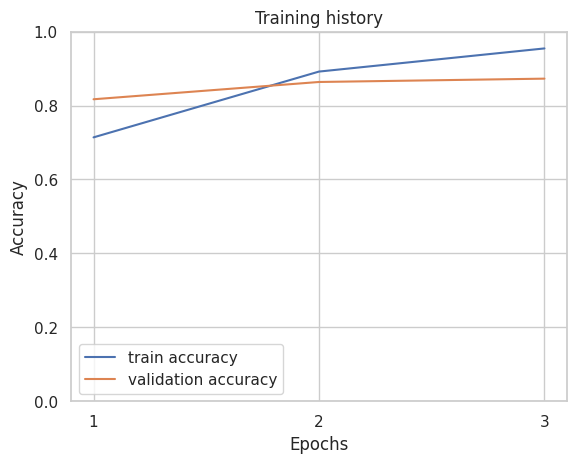

In [60]:
x = np.arange(1, EPOCHS + 1)
plt.plot(x, history['train_acc'], label='train accuracy')
plt.plot(x, history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.xticks(x)
plt.ylim([0, 1]);

Из графика видно, что точность модели достигает своего максимума примерно на 2-й эпохе и дальше практически не растет,
поэтому достаточно 2-3-х эпох.

Оцениваем нейросеть на тестовых данных

In [61]:
# Создаем тестовый датасет и даталоудер
ds_test = CustomDataset(df_test)
test_loader = DataLoader(ds_test, batch_size=BATCH_SIZE, num_workers=5)

In [62]:
# Точность на тестовой выборке
print("Считаем точность на тестовой выборке...")
_, test_acc = eval_bert(net, device, criterion, test_loader)
round(test_acc, 3)

Считаем точность на тестовой выборке...


0.895

Если обучение проводилось в Google Colab, то для дальнейшей работы с моделью нужно перенести ее вручную в папку `/models` репозитория.

После этого можно загрузить модель из файла

In [142]:
bert_cls_nn = SentencePairClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if IN_COLAB:
  bert_cls_nn.load_state_dict(torch.load(f"{ROOT}/question_pairs_bert_classifier.pt", map_location=device))
else:
  bert_cls_nn.load_state_dict(torch.load('../models/question_pairs_bert_classifier.pt', map_location=device))
bert_cls_nn.to(device)

SentencePairClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

Напишем функцю для инференса

In [143]:
def get_bert_preds(net, device, data_loader, threshold=THRESHOLD):
    """
    Функция для получения предсказаний.
    """
    net.eval()

    res_preds = []
    with torch.no_grad():
        for batch_id, (input_ids, attn_masks, token_type_ids) in enumerate(data_loader):
            input_ids, attn_masks, token_type_ids = input_ids.to(device), attn_masks.to(device), token_type_ids.to(device)

            logits = net(input_ids, attn_masks, token_type_ids)
            probs = torch.sigmoid(logits).squeeze(-1)
            preds = (probs >= threshold).int()
            res_preds.extend(preds)

    res_preds = torch.stack(res_preds).cpu().numpy()
    return res_preds

Протестируем на произвольном примере

In [144]:
# Тестовый пример
df = df_train.loc[:20, :]
ds = CustomDataset(df, with_labels=False)
data_loader = DataLoader(ds, batch_size=BATCH_SIZE, num_workers=5) # На локальном ПК без GPU лучше ставить num_workers=0

In [145]:
# Получаем предсказания
%time preds = get_bert_preds(bert_cls_nn, device, data_loader)
preds

CPU times: user 310 ms, sys: 223 ms, total: 533 ms
Wall time: 759 ms


array([1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
      dtype=int32)

In [146]:
# Выводим отчет с метриками
pd.DataFrame(classification_report(df['label'], preds, output_dict=True)).transpose()

,precision,recall,f1-score,support
0,1.000000,0.900000,0.947368,10.000000
1,0.916667,1.000000,0.956522,11.000000
accuracy,0.952381,0.952381,0.952381,0.952381
macro avg,0.958333,0.950000,0.951945,21.000000
weighted avg,0.956349,0.952381,0.952163,21.000000


Вывод: дообученная модель BERT с линейным слоем показала самую большую точность классификации,
однако у нее большой размер, и инференс без GPU может занимать много времени.
Поэтому выбор модели зависит от контекста задачи, включая достаточный уровень точности, требований по времени и наличия вычислительных ресурсов.
Далее предусмотрим возможность выбора между двумя этими вариантами, а также отключение классификатора для ускорения поиска похожих вопросов.

### 9. Поиск похожих вопросов с учетом предсказаний классификатора <a id="step_9"></a>

Напишем функцию, которая по заданному тексту будет искать индексы ближайших к нему вопросов по векторному растоянию, а потом отбирать из них те,
для которых классификатор выдает `1`. Для векторизации вопросов используем BERT, а для классификации CatBoostClassifier либо BERT с добавленным линейным слоем в зависимости от выбора пользователя. Также можно искать вопросы без учета классификатора, т.е. только по векторной близости.

Сначала напишем две вспомогательные функции, по одной для каждого типа классификатора, которые делают инференс
для левых (запрос слева) и правых (запрос справа) пар, образованных запросом пользователя и всеми отсортированными по близости к нему
вопросами корпуса.

In [147]:
def get_all_cb_preds(query_embed, bert_embeds, close_embed_inds, cb_cls_model):
    """
    Получение инференсов от catboost-классификатора для левых (запрос пользователя стоит слева от вопроса из датасета) и
    правых (запрос справа) пар, образованных запросом пользователя и всеми отсортированными по близости к нему вопросами из корпуса.

    Args:
        - query_embed (ndarray): BERT-эмбединг запроса пользователя,
        - bert_embeds (ndarray): BERT-эмбединги всех вопросов корпуса,
        - close_embed_inds (ndarray): индексы вопросов корпуса, отсортированные по близости к запросу пользователя,
        - cb_cls_model (CatBoostClassifier): обученный catboost-классификатор для пар вопросов.

    Returns:
        - Два списка с предсказаниями классификатора для всех левых и правых пар.
    """
    # Сколько инференсов нужно сделать
    n = len(close_embed_inds)
    # Бродкастим эмбединг запроса на всю колонку
    query_embed_col = np.vstack([query_embed] * n)

    # Считаем предсказания для левых пар
    left_embed_pairs = np.hstack([query_embed_col, bert_embeds[close_embed_inds]])
    left_preds = cb_cls_model.predict(left_embed_pairs)

    # Считаем предсказания для правых пар
    right_embed_pairs = np.hstack([bert_embeds[close_embed_inds], query_embed_col])
    right_preds = cb_cls_model.predict(right_embed_pairs)

    return left_preds, right_preds

In [148]:
def get_all_bert_preds(query_text, questions, close_embed_inds, bert_cls_nn):
    """
    Получение инференсов от BERT-классификатора для всех левых (запрос пользователя стоит слева от вопроса из датасета) и
    правых (запрос справа) пар, образованных запросом пользователя и всеми отсортированными по близости к нему вопросами из корпуса.

    Args:
        - query_text (str): текст запроса пользователя,
        - questions (pd.DataFrame): корпус вопрсов,
        - close_embed_inds (ndarray): индексы вопросов корпуса, отсортированные по близости к запросу пользователя,
        - bert_cls_nn (SentencePairClassifier): дообученный BERT с линейным слоем.

    Returns:
        - Два списка с предсказаниями классификатора для всех левых и правых пар.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Считаем предсказания для левых пар
    df_left = pd.concat([pd.Series(), questions.loc[close_embed_inds, 'question']], axis=1)
    df_left.rename(columns={0: 'question_1', 'question': 'question_2'}, inplace=True)
    df_left.fillna(query_text, inplace=True)
    df_left = df_left.reset_index().drop(columns='index')

    ds_left = CustomDataset(df_left, with_labels=False)
    left_loader = DataLoader(ds_left, batch_size=BATCH_SIZE, num_workers=0) # На локальном ПК без GPU лучше ставить num_workers=0
    left_preds = get_bert_preds(bert_cls_nn, device, left_loader)

    # Считаем предсказания для правых пар
    df_right = pd.concat([questions.loc[close_embed_inds, 'question'], pd.Series()], axis=1)
    df_right.rename(columns={'question': 'question_1', 0: 'question_2'}, inplace=True)
    df_right.fillna(query_text, inplace=True)
    df_right = df_right.reset_index().drop(columns='index')

    ds_right = CustomDataset(df_right, with_labels=False)
    right_loader = DataLoader(ds_right, batch_size=BATCH_SIZE, num_workers=0) # На локальном ПК без GPU лучше ставить num_workers=0
    right_preds = get_bert_preds(bert_cls_nn, device, right_loader)

    return left_preds, right_preds

In [149]:
def find_similar_questions_inds(query_text,
                                bert_model,
                                bert_embeds,
                                cb_cls_model,
                                bert_cls_nn,
                                cls_option,
                                metric='cosine',
                                n=10):
    """
    Поиск индексов n ближайших вопросов с учетом предсказаний классификатора, обученного на парах вопросов.

    Agrs:
        - query_text (str): текст, введенный пользователем,
        - bert_model (SentenceTransformer): языковая BERT-модель для векторизации текстов,
        - bert_embeds (ndarray): BERT-эмбединги всех вопросов корпуса,
        - cb_cls_model (CatBoostClassifier): обученный catboost-классификатор,
        - bert_cls_nn (SentencePairClassifier): дообученный BERT с линейным слоем,
        - cls_option (str): выбранный пользователем классификатор ('None', 'CatBoostClassifier', 'Fine-tuned BERT'),
        - metric (str): метрика для расчета расстояний,
        - n (int): количество похожих вопросов, которое нужно найти.

    Returns:
        Список из n индексов ближайших вопросов.
    """
    # Кодируем запрос
    query_embed = bert_model.encode(query_text, convert_to_tensor=False).reshape(1, -1)
    # Находим расстояния от заданного вектора до всех остальных в корпусе вопросов
    dists = pairwise_distances(query_embed, bert_embeds, metric=metric).squeeze()

    # Если расстояние до самого близкого вопроса меньше определенного значения,
    # то считаем, что он совпадает с заданным вопросом и его можно игнорировать
    if dists[0] < 1:
        close_embed_inds = np.argsort(dists)[1:]
    else:
        close_embed_inds = np.argsort(dists)

    # Корректируем n
    n = min(n, len(close_embed_inds))

    # Если пользователь выбрал классификатор, который незагружен
    if (cls_option == 'CatBoostClassifier' and cb_cls_model == None) or \
        (cls_option == 'Fine-tuned BERT' and bert_cls_nn == None):
        cls_option = 'None'

    if cls_option == 'None':
        # Классификатор не нужен
        return close_embed_inds[:n]
    elif cls_option == 'CatBoostClassifier':
        # Делаем инференс для всех левых и правых пар с помощью catboost
        left_preds, right_preds = get_all_cb_preds(query_embed, bert_embeds, close_embed_inds, cb_cls_model)
    else:
        # Делаем инференс для всех левых и правых пар с помощью BERT
        left_preds, right_preds = get_all_bert_preds(query_text, questions, close_embed_inds, bert_cls_nn)

    # Фильтруем полученные индексы с учетом предсказаний классификатора
    res_inds = [] # Результирующий список индексов
    inds_labeled_0 = [] # Список индексов векторов, для которых классификатор выдал 0
    labels_1_cnt = 0 # Счетчик единиц

    for i, embed_idx in enumerate(close_embed_inds):
        # Проверяем предсказание для левой пары
        if left_preds[i] == 1:
            res_inds.append(embed_idx)
            labels_1_cnt += 1
        else:
            # Проверяем предсказание для правой пары
            if right_preds[i] == 1:
                res_inds.append(embed_idx)
                labels_1_cnt += 1
            else:
                inds_labeled_0.append(embed_idx)

        if labels_1_cnt == n:
            break

    # Если количество найденных индексов с 1 оказалось меньше n, то добавляем индексы ближайших векторов,
    # для которых классификатор выдал 0
    for i in range(n - labels_1_cnt):
        res_inds.append(inds_labeled_0[i])

    return res_inds

Протестируем данные функции для различных сценариев

In [150]:
# Загружаем catboost-классификатор
cb_cls_model = CatBoostClassifier()
if IN_COLAB:
    cb_cls_model.load_model(f'{ROOT}/question_pairs_cb_classifier.cbm')
else:
    cb_cls_model.load_model('../models/question_pairs_cb_classifier.cbm')

In [151]:
# Загружаем BERT-классификатор
bert_cls_nn = SentencePairClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if IN_COLAB:
    bert_cls_nn.load_state_dict(torch.load(f'{ROOT}/question_pairs_bert_classifier.pt', map_location=device))
else:
    bert_cls_nn.load_state_dict(torch.load('../models/question_pairs_bert_classifier.pt', map_location=device))
bert_cls_nn.to(device)

SentencePairClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [152]:
# Вопрос пользователя
query_1 = "How to cope with stress?"

Вариант без классификатора

In [153]:
print("Ищем похожие вопросы без использования классификатора...")
%time inds_11 = find_similar_questions_inds(query_1, bert_model, bert_embeds, cb_cls_model, bert_cls_nn, 'None')
list(questions.iloc[inds_11, :]['question'].values)

Ищем похожие вопросы без использования классификатора...
CPU times: user 21.7 ms, sys: 1.93 ms, total: 23.6 ms
Wall time: 41.1 ms


['I have tension headaches and have been under lot of stress. What do you recommend i do?',
 'I need some advice, on how to manage anxiety and depression? They have been ruining my life. ',
 'What are some measures to tackle anxiety?',
 'Any tips on how to get my hair to stop falling out and start growing from stress? I had a large test I took at beginning of June stress from that',
 'Do you think being stressed for a year or so can have effects on hair? I am 34 year old male and have gray hair. Do you have any tips?',
 'I feel like depression and anxiety are ruining my life, need some advice?',
 'I have been dealing with bad anxiety for the past few weeks and I do not want to take any medicine. Are there any remedies or simple things that I can try to feel better?',
 'I have excessive hair loss due to stress. I got tested at the beginning of June. Any tips on how to deal with this hair loss and to grow back my hair?',
 'How do I get over my family issues before leaving for college?',


Вариант с CatBoostClassifier

In [154]:
print("Ищем похожие вопросы с использованием CatBoostClassifier...")
%time inds_12 = find_similar_questions_inds(query_1, bert_model, bert_embeds, cb_cls_model, bert_cls_nn, 'CatBoostClassifier')
list(questions.iloc[inds_12, :]['question'].values)

Ищем похожие вопросы с использованием CatBoostClassifier...
CPU times: user 373 ms, sys: 124 ms, total: 497 ms
Wall time: 402 ms


['I have tension headaches and have been under lot of stress. What do you recommend i do?',
 'I need some advice, on how to manage anxiety and depression? They have been ruining my life. ',
 'What are some measures to tackle anxiety?',
 'Any tips on how to get my hair to stop falling out and start growing from stress? I had a large test I took at beginning of June stress from that',
 'Do you think being stressed for a year or so can have effects on hair? I am 34 year old male and have gray hair. Do you have any tips?',
 'I feel like depression and anxiety are ruining my life, need some advice?',
 'I have been dealing with bad anxiety for the past few weeks and I do not want to take any medicine. Are there any remedies or simple things that I can try to feel better?',
 'I have excessive hair loss due to stress. I got tested at the beginning of June. Any tips on how to deal with this hair loss and to grow back my hair?',
 'How do I get over my family issues before leaving for college?',


Вариант с BERT-классификатором (лучше запускать на GPU)

In [113]:
print("Ищем похожие вопросы с использованием Fine-tuned BERT...")
%time inds_13 = find_similar_questions_inds(query_1, bert_model, bert_embeds, cb_cls_model, bert_cls_nn, 'Fine-tuned BERT')
list(questions.iloc[inds_13, :]['question'].values)

Ищем похожие вопросы с использованием Fine-tuned BERT...
CPU times: user 2min 3s, sys: 251 ms, total: 2min 3s
Wall time: 2min 8s


['I have tension headaches and have been under lot of stress. What do you recommend i do?',
 'I need some advice, on how to manage anxiety and depression? They have been ruining my life. ',
 'What are some measures to tackle anxiety?',
 'Any tips on how to get my hair to stop falling out and start growing from stress? I had a large test I took at beginning of June stress from that',
 'I have excessive hair loss due to stress. I got tested at the beginning of June. Any tips on how to deal with this hair loss and to grow back my hair?',
 'How do I get over my family issues before leaving for college?',
 'What are some ways to cope if I have not been getting enough rest for 3 days?',
 'What to do about depression of seeing spirits and just being upset overall?',
 'I see spirits and I get depressed about it. I also get upset easily without reason and this is affecting my daily routine and career. What can I do to find some relief?',
 'How to live if you hate your life and your too afraid t

Вывод: видим, что в данной задаче благодаря качеству эмбедингов BERT у нас получается
практически одинаковый набор вопросов, как при использовании классификаторов, так и без них.